# Heat equation: 
 
\begin{align}
\frac{\partial u}{\partial t} &= \nabla^2u + f
\end{align}

In this example, we use $f = \beta - 2 - 2\alpha$, where $\beta$ and $\alpha$ are constants.

The solution is known to be $u = 1 + x^2 + \alpha y^2 + \beta t$

In [1]:
!sudo pip install sklearn
print("Done!")

You should consider upgrading via the 'pip install --upgrade pip' command.
Done!


In [2]:
from fenics import *
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

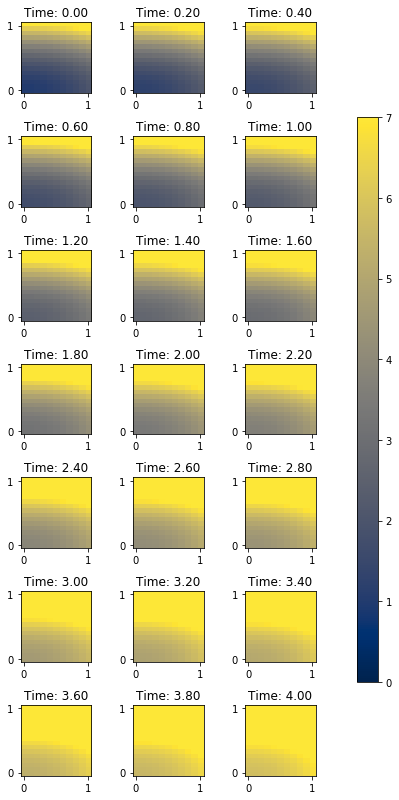

In [3]:
def calculate_simulation(nx, ny, nt, dt=None, tmax=None, alpha=6, beta=1.2):
    if dt is not None and tmax is not None:
        raise ValueError("For a given number of points, dt and tmax cannot both be defined.")
    elif dt is None and tmax is None:
        raise ValueError("For a given number of points, either dt or tmax should be set.")
    elif dt is None:
        dt = tmax/nt
    elif tmax is None:
        tmax = dt*nt
    
    # Mesh setup
    mesh = UnitSquareMesh(nx, ny)
    mesh_info = {'mesh':mesh, 'nx':nx, 'ny':ny, 'nt':nt, 'dt':dt, 'tmax':tmax}

    # Functions setup
    V = FunctionSpace(mesh, 'P', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    # Boundary setup
    def boundary(x, on_boundary):
        return on_boundary
    u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=alpha, beta=beta, t=0)
    bc = DirichletBC(V, u_D, boundary)

    # Initial values
    t = 0
    u_n = interpolate(u_D, V)

    # Variational problem
    f = Constant(beta - 2 - 2*alpha)
    a = u*v*dx + dt*dot(grad(u), grad(v))*dx
    L = (dt*f+u_n)*v*dx
    
    # Logs
    logs = {'t':[], 'u':[], 'error_L2':[], 'error_max':[]}
    
    #Log initial values
    logs['t'].append(t)
    logs['u'].append(u_n.copy(deepcopy=True))
    logs['error_L2'].append(0)
    logs['error_max'].append(0)
    
    # Solving
    u = Function(V)
    for i in range(nt):
        t += dt
        u_D.t = t
        solve(a == L, u, bc)
        u_n.assign(u)

        #Get error
        vertex_values_u_D = u_D.compute_vertex_values(mesh)
        vertex_values_u = u.compute_vertex_values(mesh)
        error_L2 = errornorm(u_D, u_n, norm_type='L2')
        error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

        # Log current values
        logs['t'].append(t)
        logs['u'].append(u_n.copy(deepcopy=True))
        logs['error_L2'].append(error_L2)
        logs['error_max'].append(error_max)
        
    return mesh_info, logs


def display_simulation(mesh_info, logs, nplots_max=None, nrows_max=None, show_bounds=False, square=True, scalemin=1, scalemax=8):
#If square is false, each image becomes a rectangle so that each pixel/vertex is of equal aspect
#Scalemin and scalemax are decided arbitrarily to scale the colour of all images to the same standard
#Ideally, we would scale everything based on the absolute min and max values of u over across all time points,
#but here we are plotting the first  before doing the entire calculation.

    # Retrieve variables
    mesh = mesh_info['mesh']
    nx = mesh_info['nx']
    ny = mesh_info['ny']
    nt = mesh_info['nt']
    u_hist = logs['u']
    t_hist = logs['t']

    # Default values
    if nplots_max is None: 
        nplots_max = 1e19
    if nrows_max is None:
        nrows_max = 1e19
    nplots = min(nt+1, nplots_max)

    #Figure values
    ncols = int(np.ceil(nplots/nrows_max))
    nrows = int(np.ceil(nplots/ncols))
    figsize = np.array([ncols, 0.8*nrows])*2 #inches
    aspect = 1 if square else ny/nx

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    #Draw plots one at a time
    for i in range(nplots):
        ax = axes.flat[i]
        
        vertex_values_u = u_hist[i].compute_vertex_values(mesh).reshape(ny+1, nx+1) #get values
        img = ax.imshow(vertex_values_u, 
                        origin='lower', extent=(-0.05, 1.05, -0.05, 1.05), #center the pixels
                        aspect=aspect,
                        cmap='cividis', vmin=scalemin, vmax=scalemax) #colour
        ax.set_title(f'Time: {t_hist[i]:.2f}')
        
        #Tickmarks
        if show_bounds:
            maj_locator = plt.FixedLocator([0, 1])
        if not show_bounds:
            maj_locator = plt.NullLocator()
        ax.xaxis.set_major_locator(maj_locator)
        ax.yaxis.set_major_locator(maj_locator)
        ax.xaxis.set_minor_locator(plt.NullLocator())
        ax.yaxis.set_minor_locator(plt.NullLocator())

    plt.tight_layout(True)

    #Add colourbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(img, cax=cbar_ax)

    plt.show()
    
#Test
mesh_info, logs = calculate_simulation(10, 15, 20, tmax=4.0, alpha=6, beta=1.2)
display_simulation(mesh_info, logs, nrows_max=7, show_bounds=True, scalemin=0, scalemax=7)

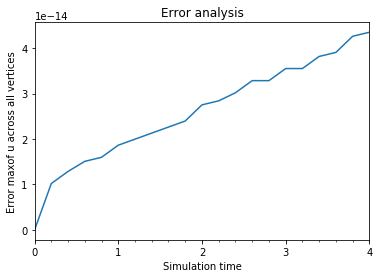

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8aa5164d30>,
 <matplotlib.lines.Line2D at 0x7f8aa09074a8>)

In [6]:
def display_error(error_type, mesh_info, logs, prev_ax=None, major_ticks_period=1, show=True):
    #the simulation time is displayed every 'major_ticks_period' times the timestep dt
    #'show' is false when the function is used as an intermediate step (if the axis will be used for further plotting)
    
    #Initialize figure and axis
    if prev_ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = prev_ax
    
    artist, = ax.plot(logs['t'], logs['error_'+error_type])
    ax.margins(x=0)
    
    ax.set_title('Error analysis')
    ax.set_xlabel('Simulation time')
    ax.set_ylabel('Error '+str(error_type)+'of u across all vertices')
    
    if show:
        ax.xaxis.set_major_locator(plt.MultipleLocator(mesh_info['dt']*major_ticks_period))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(mesh_info['dt']))
        plt.show()
    return ax, artist
    
display_error('max', mesh_info, logs, major_ticks_period=5)

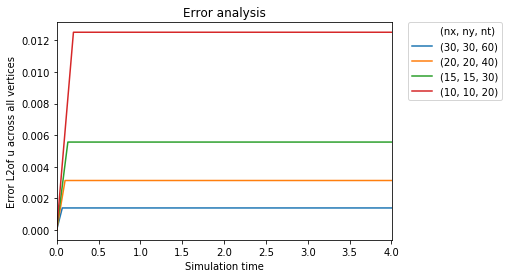

In [7]:
from matplotlib.patches import Patch

def display_errors(error_type, nxs, nys, nts, tmax):
    nxs, nys, nts = np.sort(nxs)[::-1], np.sort(nys)[::-1], np.sort(nts)[::-1]
    
    # Display setup
    prev_ax = None
    artists = []
    
    # Reuse smallest value of n_s if their are smaller values of a different n_s to get through
    len_max = max(len(nxs), len(nys), len(nts))
    for n_s in [nxs, nys, nts]:
        if len(n_s) < len_max:
            n_missing = len_max - len(n_s)
            n_s = n_s + [n_s]*n_missing
    
    # Iteration
    for i in range(len_max):
            
        # calculation step
        mesh_info, logs = calculate_simulation(nxs[i], nys[i], nts[i], tmax=tmax)
        
        # display step
        prev_ax, prev_art = display_error(error_type, mesh_info, logs, prev_ax=prev_ax, show=False)
        artists.append(prev_art)
        
    # Final touches
    empty_artist = Patch(color='white', label=str((nxs, nys, nts)))
    prev_ax.legend([empty_artist]+artists, ['(nx, ny, nt)']+list(zip(nxs, nys, nts)), 
                   bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
            
display_errors('L2', [10, 15, 20, 30], [10, 15, 20, 30], [20, 30, 40, 60], 4.0)

In [8]:
def calculate_convergence(initial_n, increase_factor_n, iterations, tmax):
    #increase_factor_n is decides how many more points are in the nest mesh
    if type(increase_factor_n) is not int:
        raise ValueError("increase_factor_n should be an integer")
    if initial_n <= 0 or type(initial_n) is not int:
        raise ValuError("initial_n should be a positive integer")
    
    # Logs
    hs = []
    errors_L2 = []
    
    for i in range(iterations):
        if i == 0:
            n = initial_n
        else:
            n *= increase_factor_n
        mesh_info, logs = calculate_simulation(n, n, n, tmax=tmax)
        print(f'n={n}\t({i+1} of {iterations})')
        hs.append(1/n)
        errors_L2.append(logs['error_L2'][-1])
        
    hs = np.array(hs)
    errors_L2 = np.array(errors_L2)
    convergence_rates = np.log(errors_L2[1:]/errors_L2[:-1])/np.log(hs[1:]/hs[:-1])
    return hs[1:], convergence_rates

hs, convergence_rates = calculate_convergence(initial_n=4, increase_factor_n=2, iterations=6, tmax=4.0)

n=4	(1 of 6)
n=8	(2 of 6)
n=16	(3 of 6)
n=32	(4 of 6)
n=64	(5 of 6)
n=128	(6 of 6)


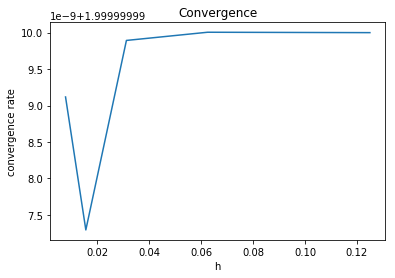

In [9]:
def display_convergence(hs, convergence_rates):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(hs, convergence_rates)
    
    ax.set_title("Convergence")
    ax.set_xlabel("h")
    ax.set_ylabel("convergence rate")
    
    plt.show()
    
display_convergence(hs, convergence_rates)

In [10]:
### Cross-sections

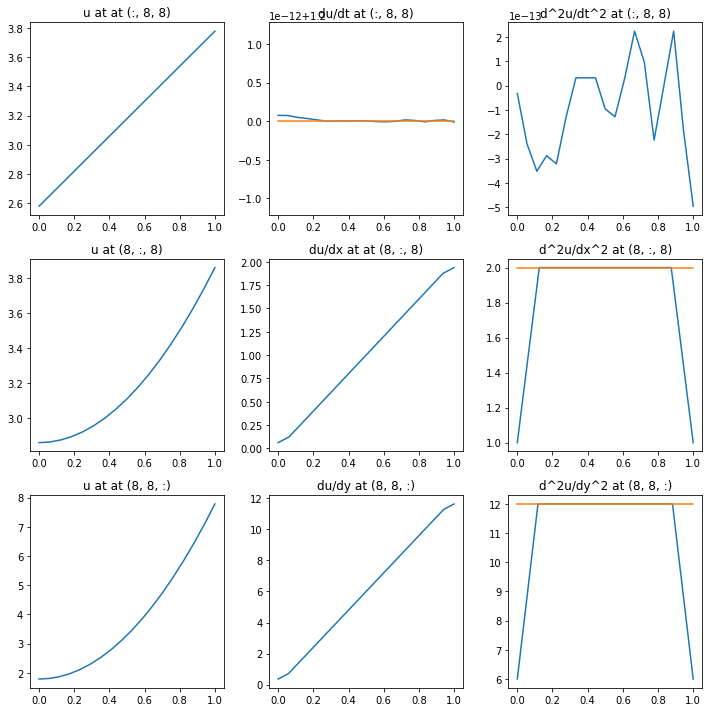

In [11]:
mesh_info, logs = calculate_simulation(16, 17, 18, tmax=1.0)

nx = mesh_info['nx']
ny = mesh_info['ny']
nt = mesh_info['nt']
coords = mesh_info['mesh'].coordinates().reshape(ny+1, nx+1, 2).transpose(1, 0, 2)
xcoords = coords[:, 0, 0]
ycoords = coords[0, :, 1]
tcoords = logs['t']
u_vals = np.array([u_at_t.compute_vertex_values().reshape(ny+1, nx+1) for u_at_t in logs['u']]).transpose(0, 2, 1)
du_vals = np.gradient(u_vals, tcoords, xcoords, ycoords)
ddu_vals = np.array([np.gradient(du_vals_dim, tcoords, xcoords, ycoords) for du_vals_dim in du_vals])
laplaceu_vals = ddu_vals.trace()
f_vals = 1.2 - 2 - 2*6

#which cross-sections do we plot?
tval_plot = 8
xval_plot = 8
yval_plot = 8

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

#along t
axes[0, 0].plot(tcoords, u_vals[:, xval_plot, yval_plot])
axes[0, 0].set_title(f'u at at (:, {xval_plot}, {yval_plot})')
axes[0, 1].plot(tcoords, du_vals[0][:, xval_plot, yval_plot])
axes[0, 1].plot(tcoords, np.full_like(tcoords, 1.2)) #ground truth
axes[0, 1].set_title(f'du/dt at (:, {xval_plot}, {yval_plot})')
axes[0, 2].plot(tcoords, ddu_vals[0, 0][:, xval_plot, yval_plot])
axes[0, 2].set_title(f'd^2u/dt^2 at (:, {xval_plot}, {yval_plot})')

#along x
axes[1, 0].plot(xcoords, u_vals[tval_plot, :, yval_plot])
axes[1, 0].set_title(f'u at ({tval_plot}, :, {yval_plot})')
axes[1, 1].plot(xcoords, du_vals[1][tval_plot, :, yval_plot])
axes[1, 1].set_title(f'du/dx at at ({tval_plot}, :, {yval_plot})')
axes[1, 2].plot(xcoords, ddu_vals[1, 1][tval_plot, :, yval_plot])
axes[1, 2].plot(xcoords, np.full_like(xcoords, 2*1)) #ground truth
axes[1, 2].set_title(f'd^2u/dx^2 at ({tval_plot}, :, {yval_plot})')

#along y
axes[2, 0].plot(ycoords, u_vals[tval_plot, xval_plot, :])
axes[2, 0].set_title(f'u at at ({tval_plot}, {xval_plot}, :)')
axes[2, 1].plot(ycoords, du_vals[2][tval_plot, xval_plot, :])
axes[2, 1].set_title(f'du/dy at ({tval_plot}, {xval_plot}, :)')
axes[2, 2].plot(ycoords, ddu_vals[2, 2][tval_plot, xval_plot, :])
axes[2, 2].plot(ycoords, np.full_like(ycoords, 2*6)) #ground truth
axes[2, 2].set_title(f'd^2u/dy^2 at ({tval_plot}, {xval_plot}, :)')

plt.tight_layout()
plt.show()

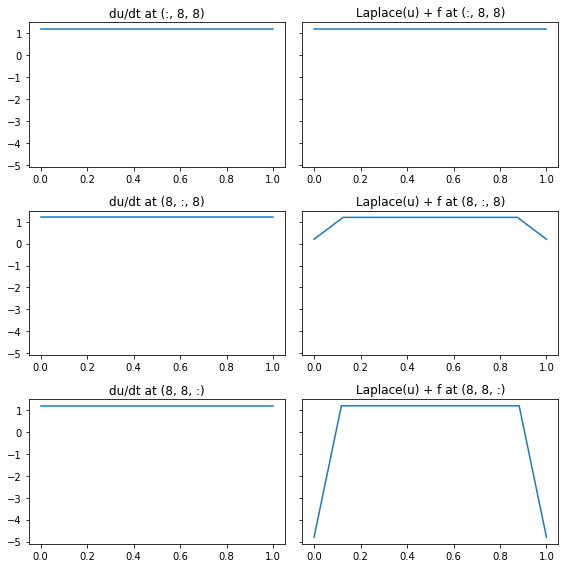

In [12]:
mesh_info, logs = calculate_simulation(16, 17, 18, tmax=1.0)

nx = mesh_info['nx']
ny = mesh_info['ny']
nt = mesh_info['nt']
coords = mesh_info['mesh'].coordinates().reshape(ny+1, nx+1, 2).transpose(1, 0, 2)
xcoords = coords[:, 0, 0]
ycoords = coords[0, :, 1]
tcoords = logs['t']
u_vals = np.array([u_at_t.compute_vertex_values().reshape(ny+1, nx+1) for u_at_t in logs['u']]).transpose(0, 2, 1) #order: t, x, y
du_vals = np.gradient(u_vals, tcoords, xcoords, ycoords)
ddu_vals = np.array([np.gradient(du_vals_dim, tcoords, xcoords, ycoords) for du_vals_dim in du_vals])
laplaceu_vals = ddu_vals[1:, 1:].trace()
f_vals = 1.2 - 2 - 2*6

#which cross-sections do we plot?
tval_plot = 8
xval_plot = 8
yval_plot = 8


fig, axes = plt.subplots(nrows=3, ncols=2, sharey='all', figsize=(8, 8))

axes[0, 0].plot(tcoords, du_vals[0][:, xval_plot, yval_plot])
axes[0, 0].set_title(f'du/dt at (:, {xval_plot}, {yval_plot})')
axes[0, 1].plot(tcoords, laplaceu_vals[:, xval_plot, yval_plot]+f_vals)
axes[0, 1].set_title(f'Laplace(u) + f at (:, {xval_plot}, {yval_plot})')

axes[1, 0].plot(xcoords, du_vals[0][tval_plot, :, yval_plot])
axes[1, 0].set_title(f'du/dt at ({tval_plot}, :, {yval_plot})')
axes[1, 1].plot(xcoords, laplaceu_vals[tval_plot, :, yval_plot]+f_vals)
axes[1, 1].set_title(f'Laplace(u) + f at ({tval_plot}, :, {yval_plot})')

axes[2, 0].plot(ycoords, du_vals[0][tval_plot, xval_plot, :])
axes[2, 0].set_title(f'du/dt at ({tval_plot}, {xval_plot}, :)')
axes[2, 1].plot(ycoords, laplaceu_vals[tval_plot, xval_plot, :]+f_vals)
axes[2, 1].set_title(f'Laplace(u) + f at ({tval_plot}, {xval_plot}, :)')


plt.tight_layout()
plt.show()

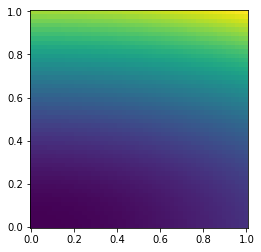

In [13]:
uvals = logs['u'][0].compute_vertex_values()
xyvals = mesh_info['mesh'].coordinates()
xvals = xyvals[:,0]
yvals=xyvals[:,1]

xx = np.linspace(0,1)
yy = np.linspace(0,1)

XX, YY = np.meshgrid(xx,yy)

plt.figure()
from scipy.interpolate import griddata
uu = griddata(xyvals, uvals, (XX, YY), method='linear')
plt.imshow(uu, origin='lower', extent=(-5e-3, 1+5e-3, -5e-3, 1+5e-3))

### PDE-FIND methods

In [32]:
alpha, beta = 1, 1.2
mesh_info, logs = calculate_simulation(16, 17, 18, tmax=1.0,  alpha=alpha, beta=beta)
f_vals = beta - 2 - 2*alpha

In [33]:
max_order = 2 #calculate only up to d^(max_order)u/dx^(max_order) inclusive
max_degree = 2 #calculate only up to u^(max_degree)

nt = mesh_info['nt']
nx = mesh_info['nx']
ny = mesh_info['ny']
coordinates = mesh_info['mesh'].coordinates().reshape(ny+1, nx+1, 2).transpose(1, 0, 2)
xcoords = coordinates[:, 0, 0]
ycoords = coordinates[0, :, 1]
tcoords = logs['t']

#calculate derivatives
u_vals = np.array([u_at_t.compute_vertex_values().reshape(ny+1, nx+1) for u_at_t in logs['u']]).transpose(0, 2, 1) #order: t, x, y
u_derivs_unmixed = [] #(unmixed means only u_xx or u_yy but not u_xy nor u_yx)
for i in range(max_order):
    if i == 0:
        derivs = np.array(np.gradient(u_vals, tcoords, xcoords, ycoords))
        u_derivs_unmixed.append(derivs)
    else:
        function = u_derivs_unmixed[-1]
        derivs_all = np.array([np.gradient(function_dim, tcoords, xcoords, ycoords) for function_dim in function])
        derivs_unmixed = derivs_all.diagonal().transpose(3, 0, 1, 2) #retrieve only unmixed derivatives
        #alternatively: derivs_unmixed = np.array([np.gradient(function[dim], tcoords, xcoords, ycoords)[dim] for dim in range(len(function))])
        u_derivs_unmixed.append(derivs_unmixed)
u_derivs_unmixed = np.array(u_derivs_unmixed) #shape is (order(1..n), dimension(t,x,y), tpos, xpos, ypos)

#flattening to make vector and matrix for regression
u_t = u_derivs_unmixed[0, 0, 2:-2, 2:-2, 2:-2].flatten() #removing endpoints where derivatives are wrong
theta = []
for order in range(max_order+1):
    for deg in range(max_degree+1):
        u_power_flat = u_vals[2:-2, 2:-2, 2:-2].flatten()**deg
        for dim in range(1, 3): #spacial dimensions only
            if order == 0:
                if dim == 1:
                    u_deriv_flat = np.ones_like(u_power_flat) #to have rows of u^exponent without multiplying with a derivative
                else:
                    u_deriv_flat = np.zeros_like(u_power_flat) #to conserve shape for when we declare xi (before flattening)
            else:
                u_deriv_flat = u_derivs_unmixed[order-1, dim, 2:-2, 2:-2, 2:-2].flatten()
            theta.append(u_power_flat*u_deriv_flat)
theta = np.array(theta).T

#In this linear system, rows are ordered (t0,x0,y0)...(t0,x0,yn),(t0,x1,y0)......(t0,xm,yn),(t1,x0,y0).........(tl,xm,yn)
#                       cols are ordered u^0, 0, u^1, 0, ...u^n, 0, u^0*u_x, u^0*u_y, u^1*u_x, u^1*u_y ... u^n*u_x, u^n*u_y, u^0*u_xx, u^0*u_yy, ......u^n*u_xxx, u^n*u_yyy
#In other words, ti are on rows where row//(nx*ny) == i, xi are on rows where row//ny == j*nx+i for all j
#xi are on rows where (j*nx+i)*yn < row < (j*nx+i+1)*yn-1 for all j

In [25]:
def stridge(theta, u_t, alpha, tol, iters, random_state=0): #alpha is this implementation's name for the paper's lambda
    if iters == 0: #recursion end, final guess
        model = Ridge(alpha=alpha, fit_intercept=True, normalize=False, copy_X=True) #SHOULD IT BE RIDGE OR OLS?
        model.fit(theta, u_t)
        xi_guess = model.coef_
        return xi_guess
    else:
        model = Ridge(alpha=alpha, fit_intercept=False, normalize=False, copy_X=True)
        model.fit(theta, u_t)
        xi_guess = model.coef_
        print(f"{iters}: {xi_guess}")
        selected_features, = np.where(np.abs(xi_guess) < tol) #unpacked the tuple, because indexing the 2d array theta with a tuple selects the wrong axis
        new_theta = theta.copy()
        new_theta[:, selected_features] = 0
        xi_guess[selected_features] = 0
        print(f"{iters}: {xi_guess}")
        print()
        return stridge(new_theta, u_t, alpha, tol, iters-1) #recursion step
    
def calculate_error(theta_test, u_t_test, xi_guess, l0_penalty):
    return np.linalg.norm(np.dot(theta_test, xi_guess) - u_t_test, 2) + l0_penalty*np.linalg.norm(xi_guess, 0)

def train_stridge(theta, u_t, alpha, dtol, tol_iters, stridge_iters): #alpha is this implementation's name for the paper's lambda
    theta_train, theta_test, u_t_train, u_t_test = train_test_split(theta, u_t, test_size=0.20, shuffle=True)
    l0_penalty = 1e-3*np.linalg.cond(theta) 
    
    model_baseline = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
    model_baseline.fit(theta_train, u_t_train)
    xi_guess_best = model_baseline.coef_
    error_best = calculate_error(theta_test, u_t_test, xi_guess_best, l0_penalty)
    print(f"best: {xi_guess_best}")
    print(f"best: {error_best}")
    
    tol = dtol
    for i in range(1, tol_iters+1):
        xi_guess = stridge(theta_train, u_t_train, alpha, tol, stridge_iters)
        error = calculate_error(theta_test, u_t_test, xi_guess, l0_penalty)
        print(f"{i}: {xi_guess}")
        print(f"{i}: {error}")
        
        if error <= error_best:
            error_best = error
            xi_best = xi_guess
            tol = tol + dtol
        else:
            tol = np.max([0, tol - 2*dtol])
            dtol = 2*dtol/(tol_iters - i)
            tol = tol + dtol
    return xi_best

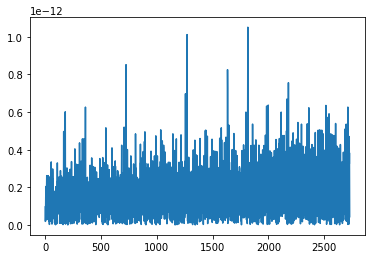

theta shape: (2730, 18)


In [26]:
#Check that the solution exists
xi = np.zeros((max_order+1, max_degree+1, 2)) #last axis is dims
xi[0, 0, 0] = f_vals #constant column
xi[2, 0] = 1 #laplace operator columns, i.e. u^0*u_xx, u^0*u_yy columns
xi_flat = xi.flatten()
u_t_reconstructed = np.dot(theta, xi_flat)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(np.abs(u_t - u_t_reconstructed))

plt.show()
print(f"theta shape: {theta.shape}")

In [41]:
#once identified which are nonzero, can it get the right values?
#Set zero columns:
theta_ish, u_t_ish = theta.copy(), u_t.copy()
theta_ish[:, 1:-6] = 0
theta_ish[:, -4:] = 0
#Set ground truth
xi_true = np.zeros((max_order+1, max_degree+1, 2)) #last axis is dims
xi_true[0, 0, 0] = f_vals #constant column
xi_true[2, 0] = 1 #laplace operator columns, i.e. u^0*u_xx, u^0*u_yy columns
xi_true = xi_true.flatten()
print(f"{xi_true}")
#Test
model = Ridge(alpha=1e-5, fit_intercept=False, normalize=False, copy_X=True) #SHOULD IT BE RIDGE OR OLS?
model.fit(theta_ish, u_t_ish)
xi_guess = model.coef_
print(xi_guess, model.intercept_)
print(f"error: {calculate_error(theta_ish, u_t_ish, xi_true, 0):}")
print(f"error: {calculate_error(theta_ish, u_t_ish, xi_guess, 0):}")

[-2.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0. ]
[ 0.13333625  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.26666411
  0.26666777  0.          0.          0.          0.        ] 0.0
error: 1.0982467542643632e-11
error: 2.5518567498977467e-08


In [19]:
xi_true = np.zeros((max_order+1, max_degree+1, 2)) #last axis is dims
xi_true[0, 0, 0] = f_vals #constant column
xi_true[2, 0] = 1 #laplace operator columns, i.e. u^0*u_xx, u^0*u_yy columns
xi_true = xi_true.flatten()
print(f"0: {xi_true}")
print()
xi_best = stridge(theta, u_t, alpha=1e5*1e-5, tol=1e4*1e-5, iters=10)
print()
print(f"best: {xi_best}")

0: [-2.8  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.
  0.   0.   0. ]

10: [ 0.1236018   0.          0.01031754  0.         -0.00261913  0.
  0.02214666  0.02182897 -0.02530551 -0.02507521  0.00674301  0.00670713
  0.2472036   0.2472036   0.02063508  0.02063508 -0.00523826 -0.00523826]
10: [ 0.1236018  0.         0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.2472036  0.2472036  0.         0.
  0.         0.       ]

9: [ 0.13332791  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.26665581
  0.26665581  0.          0.          0.          0.        ]
9: [ 0.13332791  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.26665581
  0.26665581  0.          0.          0.          0.        ]

8: [ 0.13332791  0.          0.          0.          0.         

In [20]:
xi_best = train_stridge(theta, u_t, alpha=0*1e-5, dtol=1e-5, tol_iters=10, stridge_iters=10)
print(f"best: {xi_best}")

best: [  0.00000000e+00  -2.82025666e-04   3.67561351e-03  -4.33129104e-04
   1.68996404e-04  -1.90955646e-04   2.68022598e-14   3.14518460e-14
  -1.07238180e-14  -1.69225500e-14   4.60506820e-16   2.37106943e-15
  -1.85423101e-02   2.21884225e-02   1.86916881e-02  -2.05294949e-02
  -4.51752738e-03   4.43302918e-03]
best: 4.050823412334599e+17
10: [  1.05027673e+00  -1.38727734e+00   1.21036607e-01  -8.68730720e-01
  -2.33969022e-02  -1.43550632e-01   2.60381994e-14   3.23838178e-14
  -1.15463195e-14  -1.78190795e-14   8.32667268e-16   2.32106001e-15
   5.50707091e-02   1.97909237e-02  -4.41281400e-02  -1.63901637e-02
   8.47027563e-03   3.22817548e-03]
10: [ 1.05027673 -1.38727734  0.12103661 -0.86873072 -0.0233969  -0.14355063
  0.          0.          0.          0.          0.          0.
  0.05507071  0.01979092 -0.04412814 -0.01639016  0.00847028  0.00322818]

9: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-

  0.12853494 -0.01275902 -0.10884508  0.00200979  0.02208107]

6: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
6: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005
  0.12853494 -0.01275902 -0.10884508  0.00200979  0.02208107]

5: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
5: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.       


5: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
5: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005
  0.12853494 -0.01275902 -0.10884508  0.00200979  0.02208107]

4: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
4: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005


3: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
3: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005
  0.12853494 -0.01275902 -0.10884508  0.00200979  0.02208107]

2: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
2: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005
 

   2.00979079e-03   2.20810656e-02]
2: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005
  0.12853494 -0.01275902 -0.10884508  0.00200979  0.02208107]

1: [  9.07110006e-01   6.08211818e-01   2.43208194e-01   1.54202407e-13
  -4.81817128e-02  -2.28755409e-14  -1.02648883e-14   6.22123011e-16
   4.65368581e-16  -6.73926950e-17   0.00000000e+00   0.00000000e+00
   1.79100530e-02   1.28534944e-01  -1.27590200e-02  -1.08845077e-01
   2.00979079e-03   2.20810656e-02]
1: [ 0.90711001  0.60821182  0.24320819  0.         -0.04818171  0.          0.
  0.          0.          0.          0.          0.          0.01791005
  0.12853494 -0.01275902 -0.10884508  0.00200979  0.02208107]

9: [  0.00000000e+00  -4.90804007e-06   2.11512041e-02  -6.56657899e-17
  -3.31445941e-03  -2.43035600e-17   6.11573638e-18  -1.15824563e-17
   1.15824563e-17   0.00000000e+00   1.19159785e-49   4.73131773e-45
  -4.80

In [22]:
d = np.arange(10)
t = np.arange(4*10).reshape(4, 10).T
print(d)
print(t.shape)
d_train, d_test, t_train, t_test = train_test_split(d, t, test_size=0.2, random_state=0, shuffle=True)
print(t_train)

[0 1 2 3 4 5 6 7 8 9]
(10, 4)
[[ 4 14 24 34]
 [ 9 19 29 39]
 [ 1 11 21 31]
 [ 6 16 26 36]
 [ 7 17 27 37]
 [ 3 13 23 33]
 [ 0 10 20 30]
 [ 5 15 25 35]]
